In [1]:
from shapely.geometry import Point, GeometryCollection, MultiPolygon, Polygon
from simulator.map_utils import create_regions
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as M
import numpy as np
from model.NetworkGraph import CompleteGraph
from model.NodeClass import Node
from model.LinkClass import Link
from model.NetworkGraphPlots import NodeDegreeHeatMapPlot
from numpy import random

In [2]:
graph = CompleteGraph.of_sources("../Passion_Xtreme_III.mat", "../NameTypes.xlsx")

Discarded nodes: 39
Discarded links: 0
Links: 174
Nodes: 154

*-*-* Printing information about the imported network *-*-*

Num nodes: 154
Num links: 174
Num HL4: 20
Num HL5: 134
Average distance: 2.58
Max distance (km): 22.00
Min distance (km): 0.18
Average degree: 2.27
Min degree: 1
Max degree: 10
Average degree HL4: 1.95
Average degree HL5: 2.32
Total bidirectional link length (km): 448.84


# Power sweep

/home/elig/.cache/pypoetry/virtualenvs/pof-simulation-python-Sj3CBpnm-py3.11/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/elig/.cache/pypoetry/virtualenvs/pof-simulation-python-Sj3CBpnm-py3.11/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/elig/.cache/pypoetry/virtualenvs/pof-simulation-python-Sj3CBpnm-py3.11/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/elig/.cache/pypoetry/virtualenvs/pof-simulation-python-Sj3CBpnm-py3.11/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/elig/.cache/pypoetry/virtualenvs/pof-simulatio

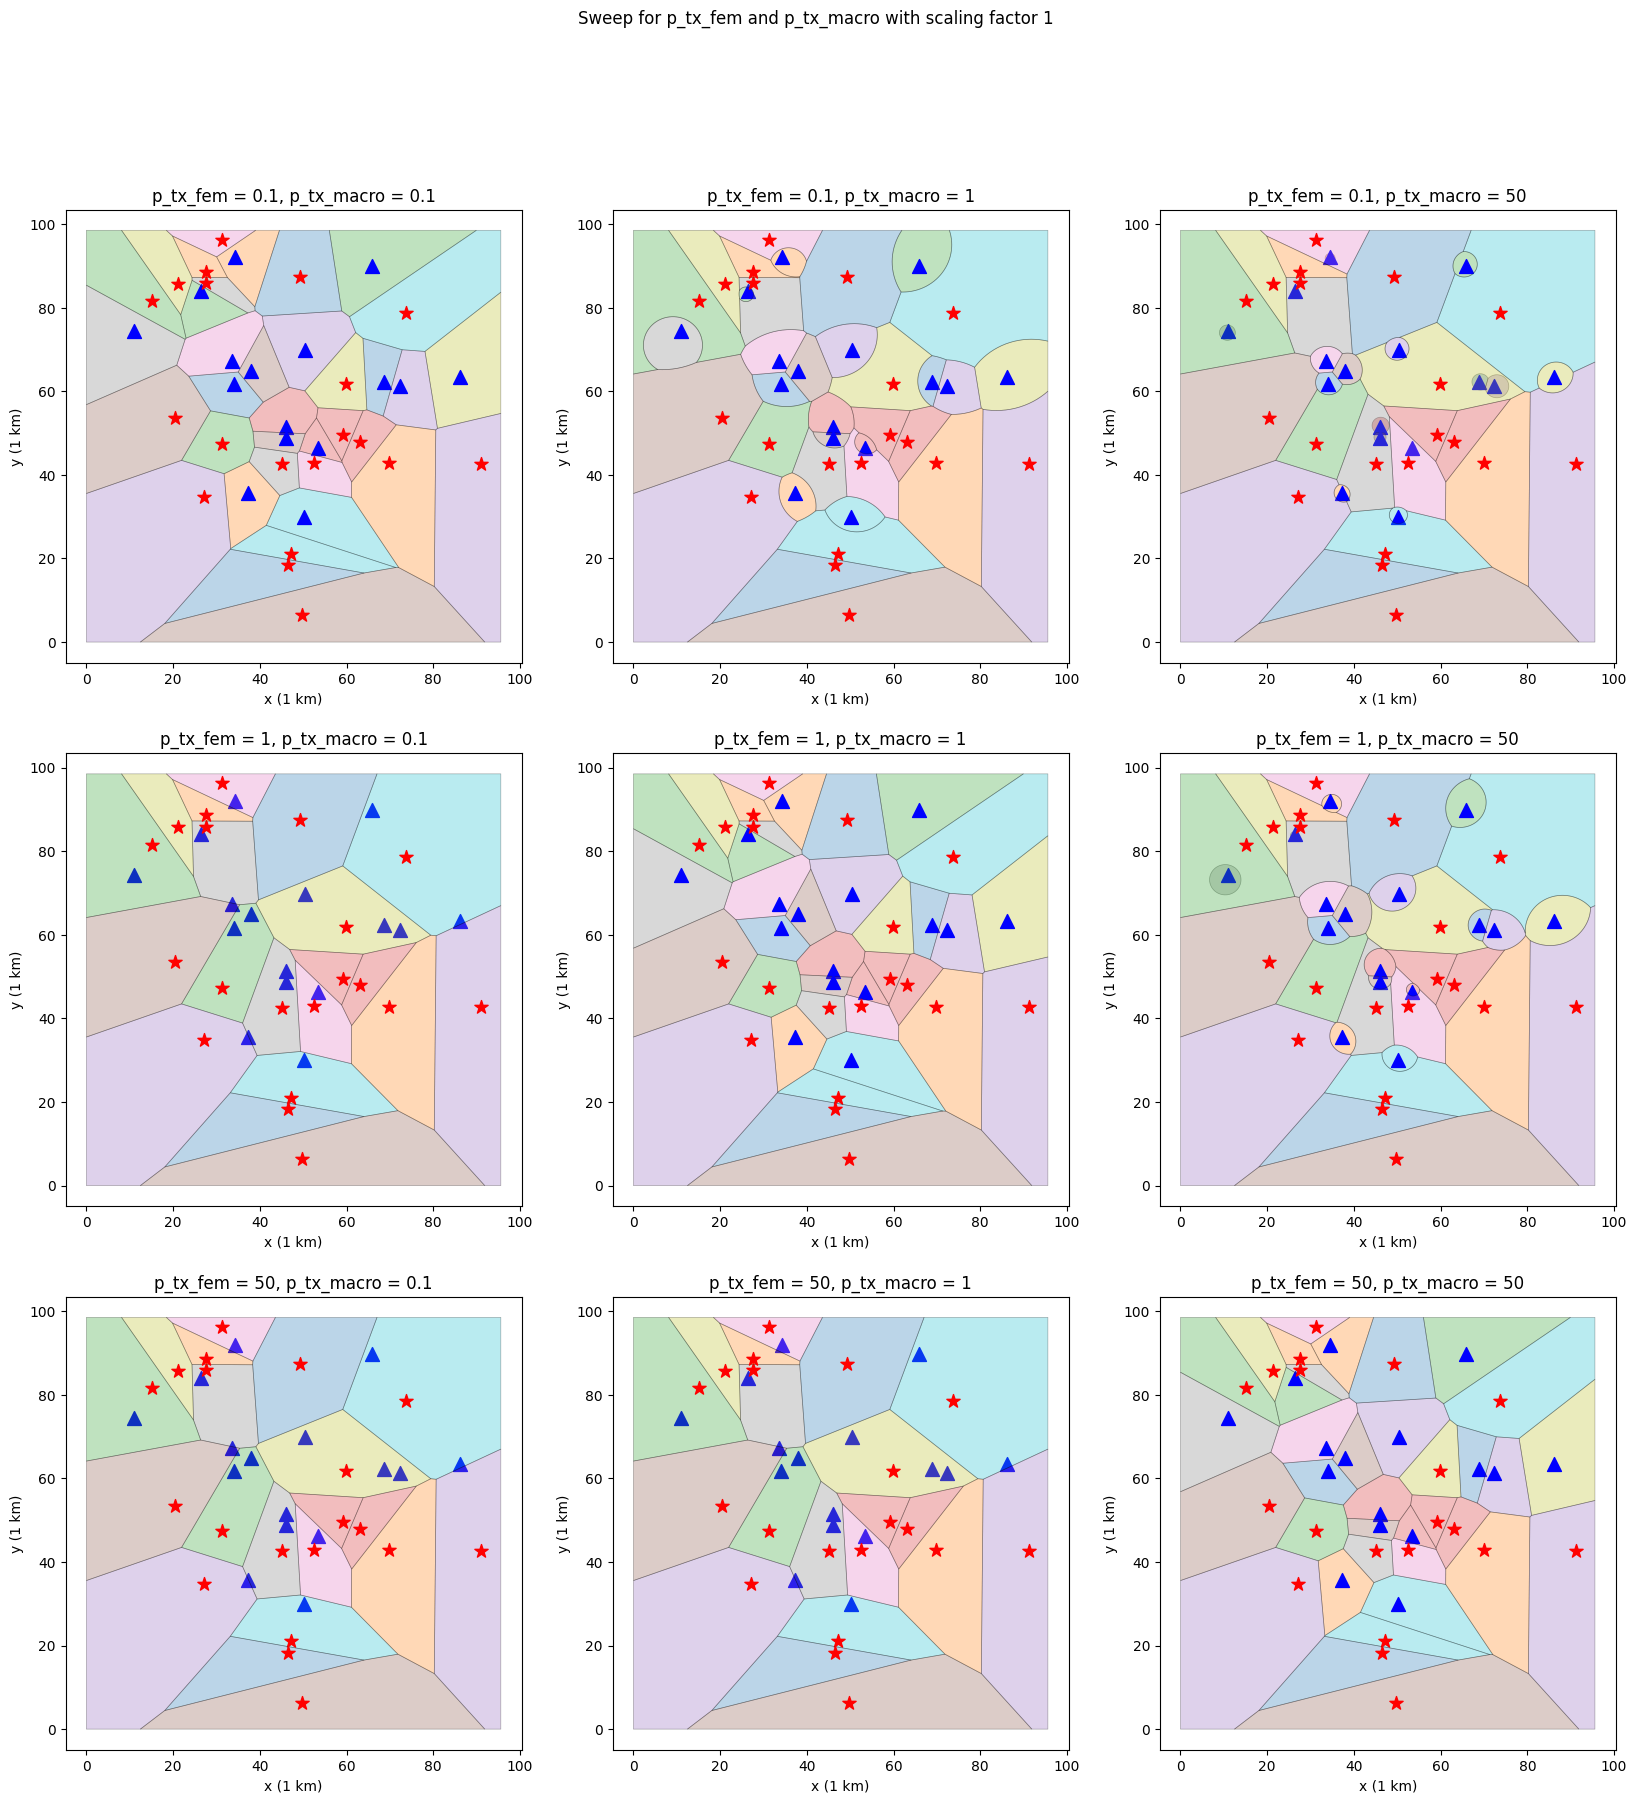

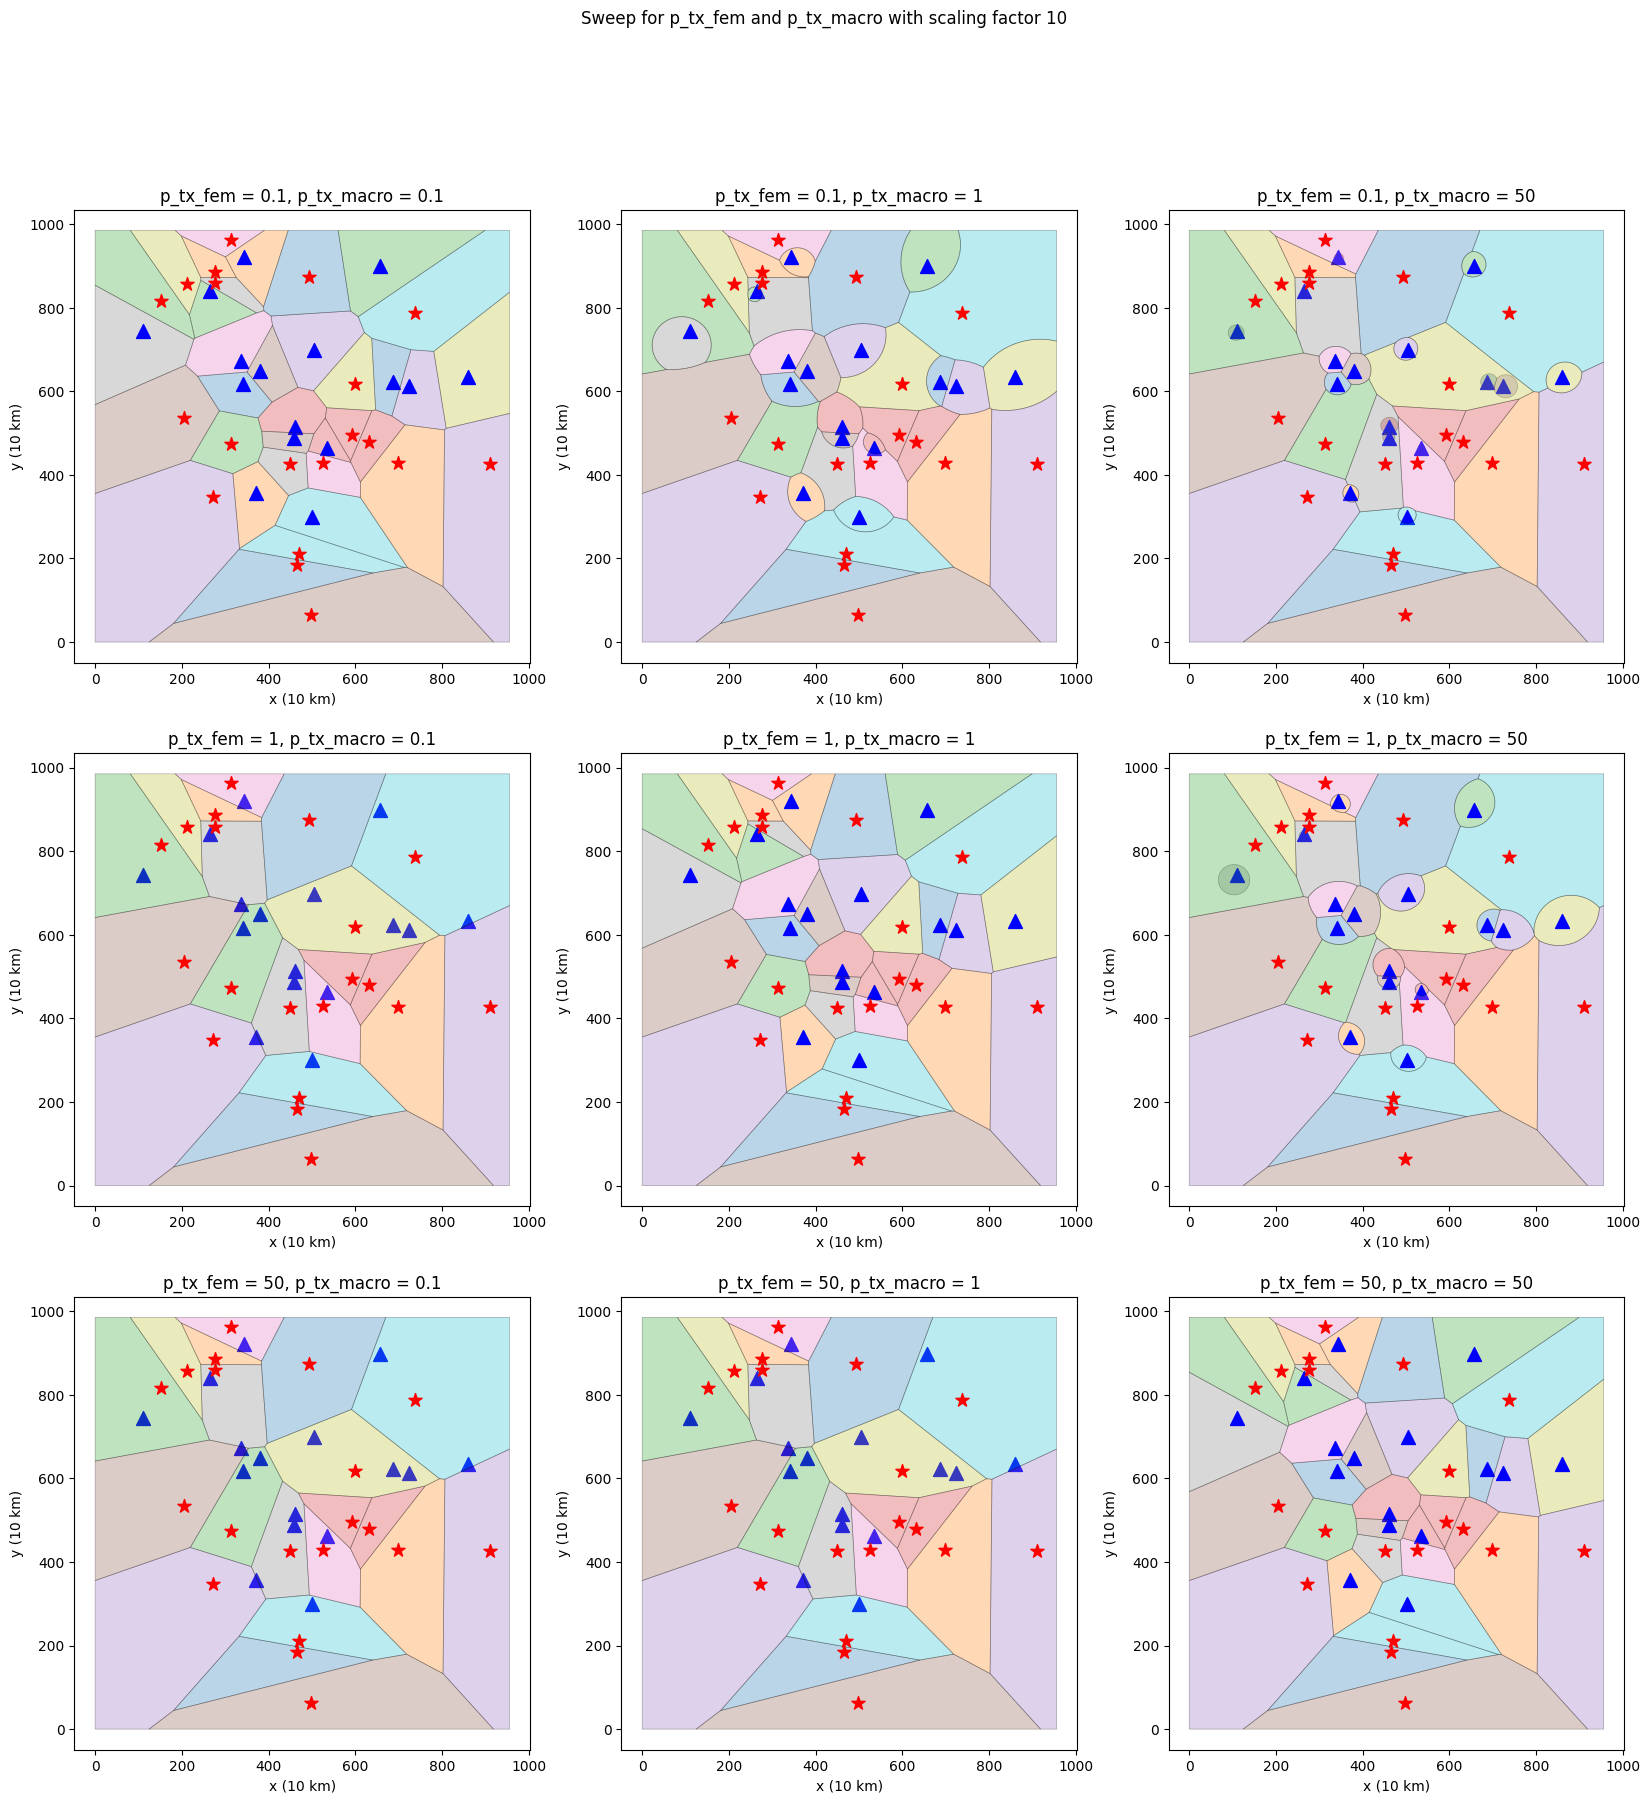

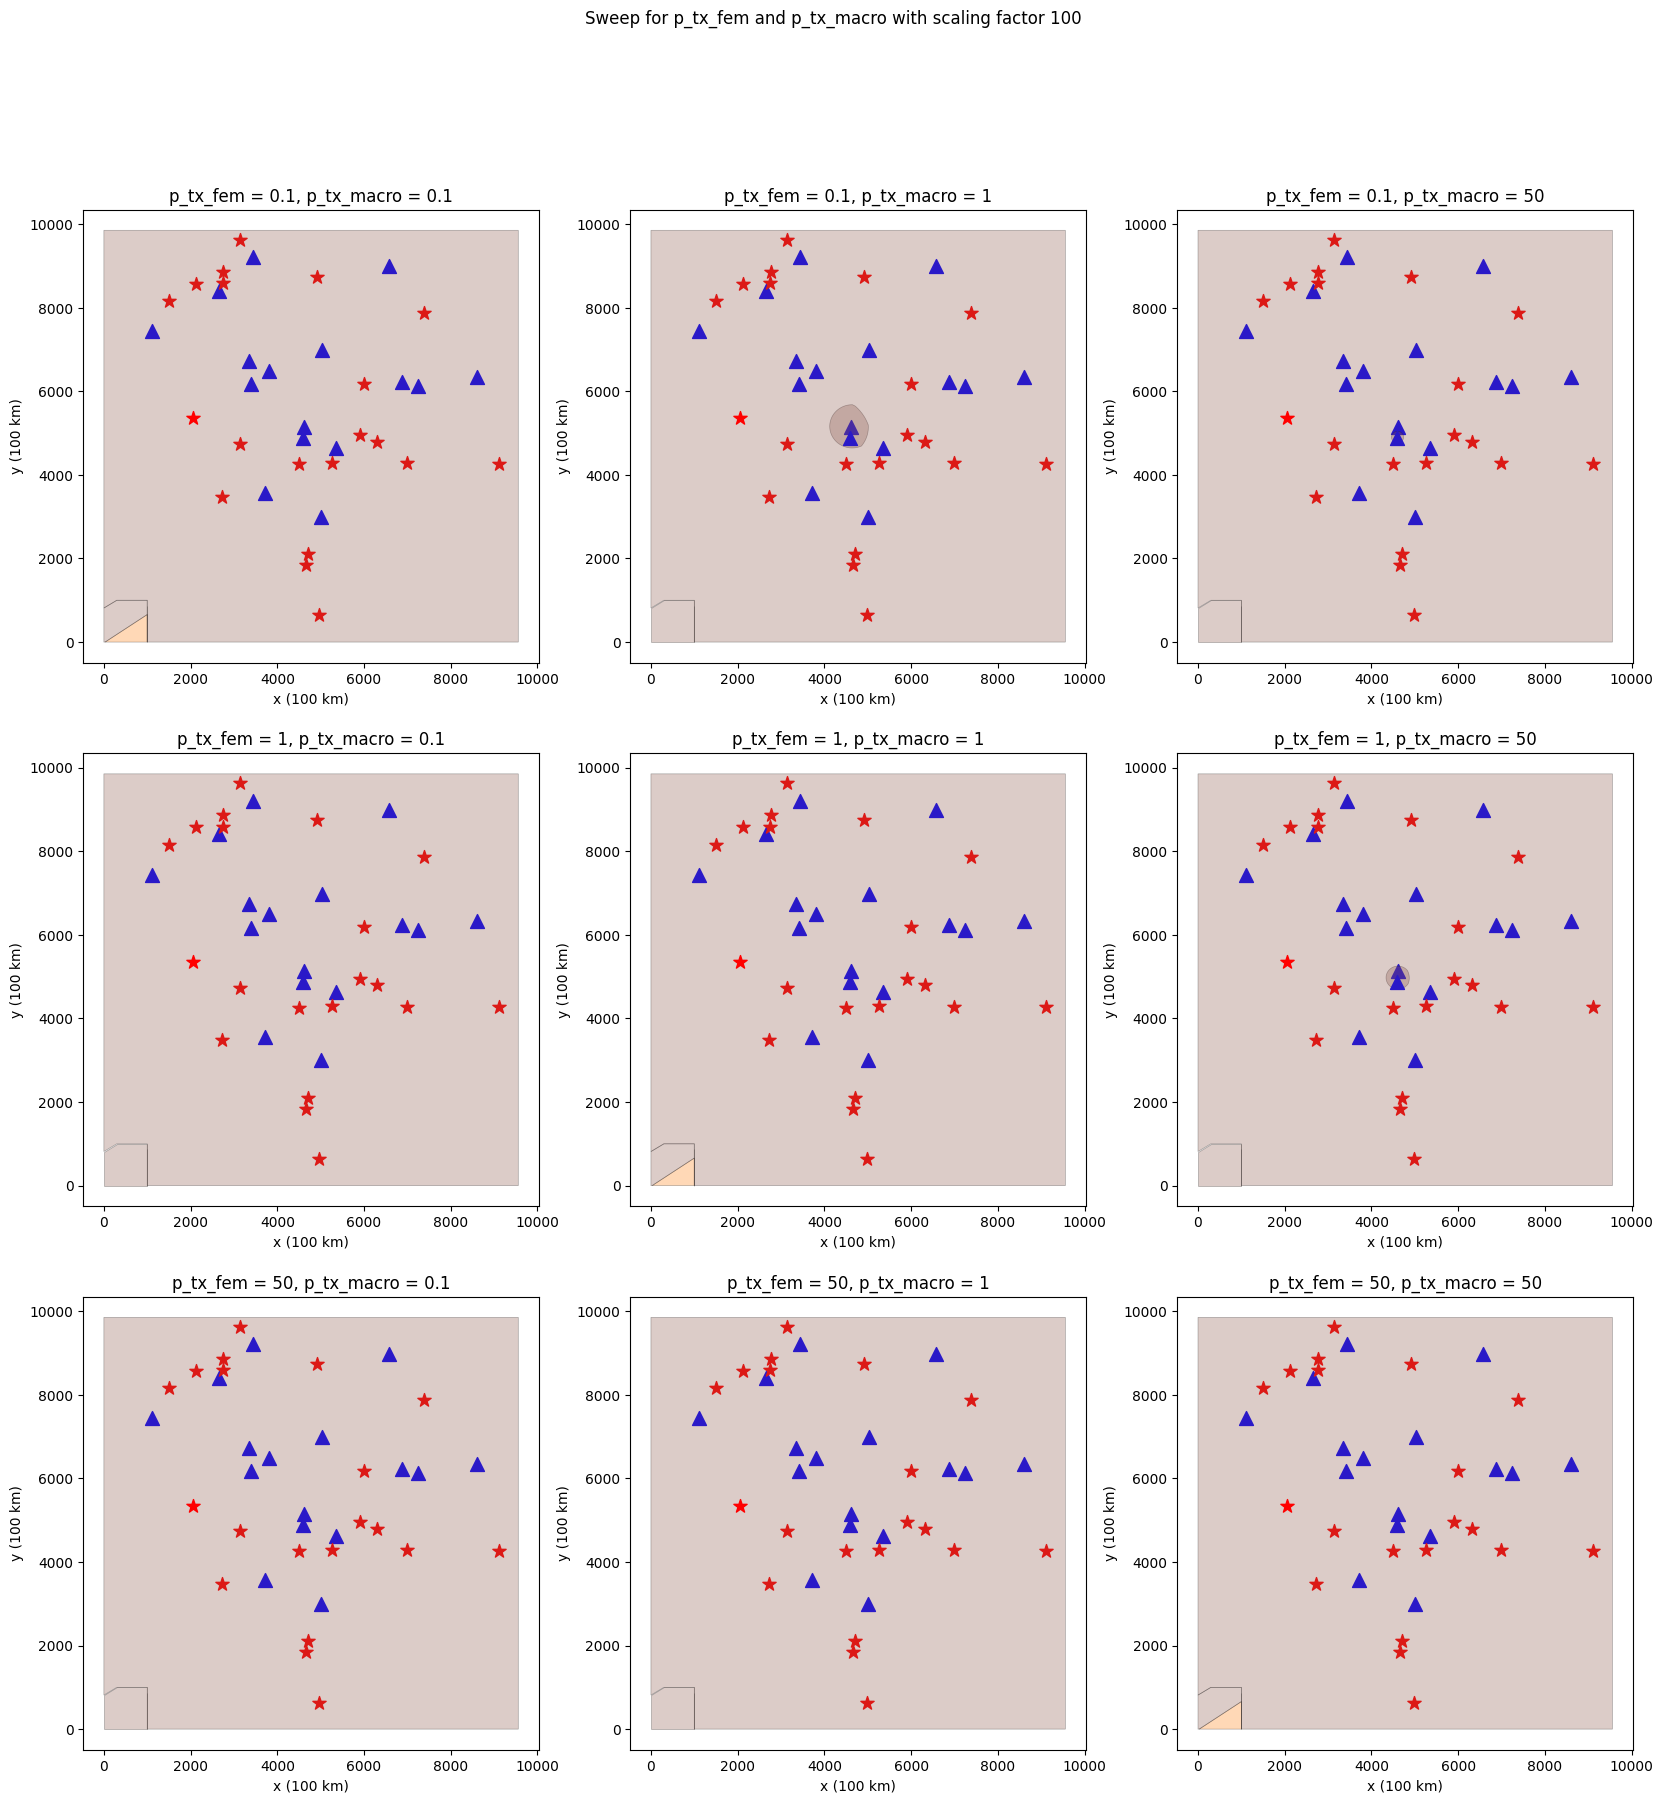

In [3]:
def choose_nodes_to_build_bs(graph):
    nodes_to_build_bs = []
    for node in graph.nodes:
        if node.type == "HL4":
            nodes_to_build_bs.append(node)
        elif random.rand() < 0.1:
            nodes_to_build_bs.append(node)
    
    # sort them, first the HL4, then the HL5
    nodes_to_build_bs.sort(key=lambda x: x.type == "HL4", reverse=True)
    return nodes_to_build_bs


def build_matrix_bs_positions(nodes_to_build_bs, polygon_bounds, scale_factor, p_tx_fem, p_tx_macro):
    cells = []
    
    for node in nodes_to_build_bs:
        if node.type == "HL4":
            # HL4 = macrocell
            cells.append((node.pos[0] * scale_factor, node.pos[1] * scale_factor, p_tx_macro))
        else:
            # HL5 = femtocell
            cells.append((node.pos[0] * scale_factor, node.pos[1] * scale_factor, p_tx_fem))
            
    base_area = [(x * scale_factor, y * scale_factor) for x, y in polygon_bounds]
    
    return cells, base_area


# Generate a graph common to all sweeps. Baseline design
nodes_to_build_bs = choose_nodes_to_build_bs(graph)
polygon_bounds = graph.network_polygon_bounds
alpha_loss = 4

sweep_p_tx = [0.1, 1, 50] # Try each combination for both p_tx_fem and p_tx_macro. 9 combinations total.
sweep_scaling_factor = [1, 10, 100] # Try each scaling factor. 3 combinations total.

# One figure for each scale factor. Inside each figure, the sweep for p_tx_fem and p_tx_macro.
for scale_factor in sweep_scaling_factor:
    fig, ax = plt.subplots(len(sweep_p_tx), len(sweep_p_tx), figsize=(20, 20))
    # fig.tight_layout()
    fig.suptitle(f"Sweep for p_tx_fem and p_tx_macro with scaling factor {scale_factor}")
    
    for i, p_tx_fem in enumerate(sweep_p_tx):
        for j, p_tx_macro in enumerate(sweep_p_tx):
            # print(f'i={i}, j={j}')
            # Build the cells and associated nodes
            cells, base_area = build_matrix_bs_positions(nodes_to_build_bs, polygon_bounds, scale_factor, p_tx_fem, p_tx_macro)
            # Create the regions (estimated coverage)
            regions = create_regions(len(cells), np.array(cells), alpha_loss, polygon_bounds=base_area)
            
            # Plot the regions
            for k in range(len(regions)-1, -1, -1):
                region = regions[k]
                if isinstance(region, Polygon):
                    x, y = region.exterior.coords.xy
                    ax[i, j].fill(x, y, alpha=0.3, edgecolor='black', linewidth=0.5)
                    
                node = nodes_to_build_bs[k]
                shape = "*" if node.type == "HL4" else "^"
                color = "red" if node.type == "HL4" else "blue"
                ax[i, j].scatter(node.pos[0] * scale_factor, node.pos[1] * scale_factor, marker=shape, s=100, color=color)
                
                
                    
                
                    
                
            
            # Plot the base stations
            # for node in assocciated_nodes:
                # shape = "*" if node.type == "HL4" else "^"
                # color = "red" if node.type == "HL4" else "blue"
                # ax[i, j].scatter(node.pos[0] * scale_factor, node.pos[1] * scale_factor, marker=shape, s=100, color=color)
            
            ax[i, j].set_xlabel(f"x ({scale_factor} km)")
            ax[i, j].set_ylabel(f"y ({scale_factor} km)")
            ax[i, j].set_title(f"p_tx_fem = {p_tx_fem}, p_tx_macro = {p_tx_macro}")
    
    


